---

# Project: Amazon Product Recommendation System

## Introduction

Welcome to the project on Recommendation Systems. We will work with the Amazon product reviews dataset for this project. The dataset contains ratings of different electronic products. It does not include information about the products or reviews to avoid bias while building the model. 


### Context

Today, information is growing exponentially with volume, velocity and variety throughout the globe. This has lead to information overload, and too many choices for the consumer of any business. It represents a real dilemma for these consumers and they often turn to denial. Recommender Systems are one of the best tools that help recommending products to consumers while they are browsing online. Providing personalized recommendations which is most relevant for the user is what's most likely to keep them engaged and help business. 

E-commerce websites like Amazon, Walmart, Target and Etsy use different recommendation models to provide personalized suggestions to different users. These companies spend millions of dollars to come up with algorithmic techniques that can provide personalized recommendations to their users.

Amazon, for example, is well-known for its accurate selection of recommendations in its online site. Amazon's recommendation system is capable of intelligently analyzing and predicting customers' shopping preferences in order to offer them a list of recommended products. Amazon's recommendation algorithm is therefore a key element in using AI to improve the personalization of its website. For example, one of the baseline recommendation models that Amazon uses is item-to-item collaborative filtering, which scales to massive data sets and produces high-quality recommendations in real-time.

### Objective

You are a Data Science Manager at Amazon, and have been given the task of building a recommendation system to recommend products to customers based on their previous ratings for other products. You have a collection of labeled data of Amazon reviews of products. The goal is to extract meaningful insights from the data and build a recommendation system that helps in recommending products to online consumers.
- Knowledge/Rank Based Recommendation System
- Similarity-Based Collaborative Filtering
- Matrix Factorization Based Collaborative Filtering

### Data Description

The Amazon dataset contains the following attributes

- user_id: Every user identified with a unique id
- prod_Id: Every product identified with a unique id
- rating: The rating of the corresponding product by the corresponding user
- timestamp: Time of the rating. We **will not use this column** to solve the current problem

---

## Importing Necessary Libraries and Data

This section sets up the environment by importing tools for data manipulation, visualization, handling special characters, and conducting statistical analysis

In [107]:
# from google.colab import drive
# drive.mount('/content/drive')

In [108]:
# Import library to suppress warnings
import warnings

warnings.filterwarnings("ignore")

In [109]:
# Import libraries for data manipulation
import numpy as np
import pandas as pd
import math

# Import libraries for data visualization
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
%matplotlib inline

# Import library for statistical analysis
import scipy.stats as stats

# Import library for random sampling
import random

# Import libraries for machine learning
from sklearn.metrics import mean_squared_error 

from IPython.display import display, Markdown

In [110]:
# To compute the accuracy of models
from surprise import accuracy

# Class is used to parse a file containing ratings, data should be in structure - user ; item ; rating
from surprise.reader import Reader

# Class for loading datasets
from surprise.dataset import Dataset

# For tuning model hyperparameters
from surprise.model_selection import GridSearchCV

# For splitting the rating data in train and test datasets
from surprise.model_selection import train_test_split

# For implementing similarity-based recommendation system
from surprise.prediction_algorithms.knns import (
    KNNBasic,
    KNNBaseline,
    KNNWithMeans,
    KNNWithZScore,
)

# For implementing matrix factorization based recommendation system
from surprise.prediction_algorithms.matrix_factorization import SVD, SVDpp

# For implementing K-Fold cross-validation
from surprise.model_selection import KFold, cross_validate

# For implementing clustering-based recommendation system
from surprise import CoClustering

# A dictionary output that does not raise a key error
from collections import defaultdict

---

## Loading Data

This section involves reading the dataset from a CSV file into a pandas DataFrame for further analysis.

In [111]:
# Read the DataFrame
data = pd.read_csv("ratings_Electronics.csv", header=None)

# Add column names
data.columns = ["user_id", "prod_id", "rating", "timestamp"]

# Drop colum 'timestamp'
data = data.drop("timestamp", axis=1)

# Create copy of the DataFrame
df = data.copy(deep=True)

# Check number of rows and columns in the dataset
df.shape

(7824482, 3)

## Data Preprocessing

Given the dataset's vast size of 7.8 million observations and the sparsity in user and product ratings, an initial approach was taken to reduce the dataset by filtering for users with at least 50 ratings and products with at least 5 ratings.

However, this approach led to a recursive loop issue, where the filtered dataset caused some users to no longer meet the rating threshold, leading to continuous data loss. To resolve this, a balanced filtering strategy was implemented, gradually adjusting thresholds with convergence checks to stabilize the dataset size, ensuring that significant data was retained without excessive reduction.

In [112]:
# Define initial thresholds
user_threshold = 30
product_threshold = 2

# Define maximum threshold increments for iterative filtering
max_user_threshold = 50
max_product_threshold = 5

# Set convergence flag and initial dataset size
converged = False
prev_size = df.shape[0]

In [113]:
# Initial filtering with low thresholds
user_ratings_count = df["user_id"].value_counts()
df = df[
    df["user_id"].isin(user_ratings_count[user_ratings_count >= user_threshold].index)
]

product_ratings_count = df["prod_id"].value_counts()
df = df[
    df["prod_id"].isin(
        product_ratings_count[product_ratings_count >= product_threshold].index
    )
]

# Set initial values for convergence check
prev_size = df.shape[0]
converged = False

while not converged:
    # Increment thresholds gradually
    if user_threshold < max_user_threshold:
        user_threshold += 1  # Increase user threshold incrementally
    if product_threshold < max_product_threshold:
        product_threshold += 1  # Increase product threshold incrementally

    # Filter users with at least the current user threshold ratings
    user_ratings_count = df["user_id"].value_counts()
    df = df[
        df["user_id"].isin(
            user_ratings_count[user_ratings_count >= user_threshold].index
        )
    ]

    # Filter products with at least the current product threshold ratings
    product_ratings_count = df["prod_id"].value_counts()
    df = df[
        df["prod_id"].isin(
            product_ratings_count[product_ratings_count >= product_threshold].index
        )
    ]

    # Check the current size of the dataset
    current_size = df.shape[0]

    # Check for convergence: if the dataset size decreases significantly, stop iterating
    if abs(prev_size - current_size) > 1000:  # Adjust this value as needed
        converged = True
    else:
        prev_size = current_size

    # If thresholds have reached maximum but no significant change, break to avoid infinite loop
    if (
        user_threshold >= max_user_threshold
        and product_threshold >= max_product_threshold
    ):
        print("Reached maximum thresholds without significant change. Stopping.")
        break

# Final thresholds applied
print(f"user_threshold: {user_threshold}")
print(f"product_threshold: {product_threshold}")

user_threshold: 31
product_threshold: 3


In [114]:
# Reset index of dataset
df.reset_index(drop=True, inplace=True)

## Data Overview

This section provides a high-level summary of the DataFrame, including the dimensions, data types, and an initial look at the first and last few rows. It checks for duplicate records and counts the unique values for each feature, confirming data integrity and providing an overview of the dataset’s structure.

### High-Level Data Information

In [115]:
# Number of rows and columns
df.shape

(131109, 3)

In [116]:
# First 5 rows
df.head()

,user_id,prod_id,rating
0,A3BMUBUC1N77U8,0972683275,4.0
1,A6J8D9V5S9MBE,0972683275,5.0
2,A3CLWR1UUZT6TG,0972683275,5.0
3,A11NR4AJK9TNQM,0972683275,4.0
4,A3TAS1AG6FMBQW,0972683275,5.0


In [117]:
# Last 5 rows
df.tail()

,user_id,prod_id,rating
131104,A34BZM6S9L7QI4,B00LGQ6HL8,5.0
131105,A1G650TTTHEAL5,B00LGQ6HL8,5.0
131106,A25C2M3QF9G7OQ,B00LGQ6HL8,5.0
131107,A1E1LEVQ9VQNK,B00LGQ6HL8,5.0
131108,A2NYK9KWFMJV4Y,B00LGQ6HL8,5.0


In [118]:
# Summary of DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131109 entries, 0 to 131108
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   user_id  131109 non-null  object 
 1   prod_id  131109 non-null  object 
 2   rating   131109 non-null  float64
dtypes: float64(1), object(2)
memory usage: 3.0+ MB


**Observations:**
- The DataFrame has **131,109 observations and 3 columns**.
- Data types include object and float64.
- No missing values, as row counts match non-null counts for each column.
- One column is numerical, the others are categorical or textual.

### Unique and Duplicate Values

In [119]:
# Number of duplicate rows
dvalues = df.duplicated().sum()

# Convert into DataFrame
duplicate_df = pd.DataFrame({"metric": ["duplicate_rows"], "count": [dvalues]})

# Display DataFrame
duplicate_df

,metric,count
0,duplicate_rows,0


In [120]:
# Number of unique values per feature
nuniq = df.nunique().reset_index()

# Rename column names
nuniq.columns = ["feature", "unique values"]

# Display DataFrame
nuniq

,feature,unique values
0,user_id,2964
1,prod_id,14571
2,rating,5


**Observations**:
- **Duplicate Records**: The dataset is free of duplicate entries, ensuring the integrity of the data.
- **User and Product Data:** There are **2,964 users** and **14,571 products**.
- **Rating Data:** A total of **43,188,444** possible ratings, the dataset includes only 131,109 ratings, resulting in a sparse dataset for the recommendation system, as not every user has rated every product.
- **Additional Details:** More insights and specifics are provided in the subsequent sections.

## Exploratory Data Analysis

### Statistical Analysis of DataFrame

In [121]:
# Select categorical and numerical columns
cat_cols = list(df.select_dtypes(include=["object"]).columns)
num_cols = list(df.select_dtypes(include=[np.number]).columns)

#### Analysis of Numerical Data

In [122]:
# Statistical summary of numerical data
df[num_cols].describe().T.round(2)

,count,mean,std,min,25%,50%,75%,max
rating,131109.0,4.29,1.02,1.0,4.0,5.0,5.0,5.0


**Observations**:
- **rating**: There are 131,109 unique ratings. The data is skewed towards higher values, with a mean of 4.29 and the majority of ratings at 5.0, indicating that most users rate their experiences positively.

#### Analysis of Categorical Data

In [123]:
# Statistical summary of categorical data
df[cat_cols].describe().T

,count,unique,top,freq
user_id,131109,2964,ADLVFFE4VBT8,360
prod_id,131109,14571,B0088CJT4U,302


**Observations**:
- **user_id**: There are 2,964 unique users, with the most active user having rated 360 products.
- **prod_id**: There are 14,571 unique products, with the most frequently rated product receiving 302 ratings.

### Defintion of Functions
This subsection contains all defined functions used for subsequent univariate data analysis.

In [124]:
# Set standard color palette for plotting
palette_colors = sns.color_palette("Set2")

# Set standard rating order and create custome color palette
rating_order = [1.0, 2.0, 3.0, 4.0, 5.0]
custom_palette = {
    str(rating): color for rating, color in zip(rating_order, palette_colors)
}

In [125]:
# Function to calculate the distribution of a categorical variable
def feature_stats(data, feature):
    rating_percentage_df = (
        data[feature]
        .value_counts(normalize=True)
        .mul(100)
        .round(2)
        .reset_index()
        .rename(columns={"index": feature, "proportion": "percentage"})
    )
    print(f"{feature.capitalize()} Distribution")
    print("-" * 30)
    print(rating_percentage_df.sort_values(by=feature).to_string(index=False))
    print("-" * 30)

In [126]:
# Function to annotate each bar in barplot
def annotate_bars(ax, total, perc=False):

    # Annotate each bar by percentage or count
    for container in ax.containers:
        labels = [
            f"{100 * height / total:.1f}%" if perc else f"{height:.0f}"
            for height in container.datavalues
        ]
        ax.bar_label(container, labels=labels, label_type="edge", fontsize=10)

In [127]:
# Function to plot categorical variables with barplot and optional relative percentage annotations
def barplot(data, feature, perc=False):

    # Display the distribution statistics for the feature
    feature_stats(data, feature)

    # Compute mean and median
    fmean = data[feature].mean()
    fmedian = data[feature].median()

    fig = plt.figure(figsize=(14, 8))
    total = len(data[feature])

    # Plot countplot
    sns.countplot(
        data=data,
        x=feature,
        palette=custom_palette,
        order=rating_order,
    )

    # Add title
    ax = plt.gca()
    formatted_title = feature.replace("_", " ").title()
    ax.set_title(f"Distribution of {formatted_title}")

    # Annotate each bar by percentage or count
    annotate_bars(ax, total, perc)

    fig.tight_layout(pad=2.0)
    plt.show()

    # Print the key statistics
    print(f"Mean: {np.round(fmean, 2)}, Median: {np.round(fmedian, 2)}")

In [128]:
# Function to plot interaction data distribution with histplot
def plot_interaction_histplot(data, groupby_feature, select_feature, ax):

    # Finding user-item interactions distribution
    count_interactions = data.groupby(groupby_feature)[select_feature].count()

    # Calculate mean and median
    mean_val = count_interactions.mean()
    median_val = count_interactions.median()
    max_val = count_interactions.max()

    # Calculate xlim rounded up to the next tick
    xlim = np.ceil(max_val / 10) * 10

    # Plot histplot
    sns.histplot(
        count_interactions,
        kde=True,
        color="green",
        edgecolor="darkgreen",
        linewidth=1.0,
        ax=ax,
    )
    # Add limits, yscale (square root), titel, and label
    ax.set_xlim(0, xlim)
    ax.set_yscale("function", functions=(np.sqrt, lambda x: x**2))
    formatted_title = groupby_feature.replace("_", " ").title()
    ax.set_title(f"Distribution of {formatted_title} Interactions")
    ax.set_xlabel("Number of Interactions")

    # Adding lines for max, mean, and median values
    ax.axvline(
        max_val,
        color="black",
        linestyle="--",
        linewidth=1.5,
        label=f"Max: {max_val:.2f}",
    )

    ax.axvline(
        mean_val,
        color="blue",
        linestyle="-",
        linewidth=1.5,
        label=f"Mean: {mean_val:.2f}",
    )

    ax.axvline(
        median_val,
        color="red",
        linestyle="-",
        linewidth=1.5,
        label=f"Median: {median_val:.2f}",
    )

    # Calculate the x-coordinate for the legend
    legend_x = max_val / xlim - 0.005

    # Add legend
    ax.legend(loc="upper right", bbox_to_anchor=(legend_x, 1))

In [129]:
# Function to plot interaction data distribution with boxplot
def plot_interaction_boxplot(data, groupby_feature, select_feature, ax):

    # Finding user-item interactions distribution
    count_interactions = data.groupby(groupby_feature)[select_feature].count()

    # Adding statistical annotations
    max_val = count_interactions.max()

    # Calculate xlim rounded up to the next tick
    xlim = np.ceil(max_val / 10) * 10

    # Plot boxplot
    sns.boxplot(
        x=count_interactions,
        ax=ax,
        color="#FFC877",
        medianprops=dict(visible=True, color="red"),
        flierprops=dict(marker="o", markersize=3),
    )
    # Add label and limits
    ax.set_xlim(0, xlim)
    ax.set_xlabel("Number of Interactions")

In [130]:
# Function to calculate and print the top 10 entries with the highest counts
def nlargest_entries(data, feature, n=10):
    top_entries = data[feature].value_counts().nlargest(10)
    top_entries_df = top_entries.reset_index()  # Converts Series to DataFrame
    top_entries_df.columns = [feature, "count"]  # Rename columns of DataFrame

    print(f"Top {n} Entries")
    print("-" * 30)
    print(top_entries_df.to_string(index=False))
    print("-" * 30)

    return top_entries

In [131]:
# Function to plot categorical variables with barplot and optional relative percentage annotations
def barplot_subplots(data, features, perc=False):

    # Extract the top 10 entries based on the total number of ratings
    top_entries = nlargest_entries(df, features[0])
    top_entries = top_entries.index

    # Determine the number of columns and rows for the subplot
    num_ids = len(top_entries)
    num_cols = int(math.ceil(math.sqrt(num_ids))) if num_ids != 3 else 3
    num_rows = int(math.ceil(num_ids / num_cols))

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 5, num_rows * 5))
    axes = axes.flatten() if num_ids > 1 else [axes]

    for i, id in enumerate(top_entries):
        data_filtered = data[data[features[0]] == id]
        total = len(data_filtered)

        ax = axes[i]
        sns.countplot(
            data=data_filtered,
            x=features[1],
            ax=ax,
            palette=custom_palette,
            order=rating_order,
        )
        ax.set_title(f"{features[0]}: {id}")

        # Annotate each bar by percentage or count
        annotate_bars(ax, total, perc)

    # Hide any unused subplots
    for j in range(num_ids, num_rows * num_cols):
        fig.delaxes(axes[j])

    # Adjust the layout
    fig.tight_layout(pad=2.0)
    plt.show()

### Univariate Analysis of Numerical Columns
For analysis purposes, the 'rating' column, consisting of discrete numbers from 1 to 5, will be treated as a categorical variable. This approach allows us to effectively observe its distribution and patterns.

#### Column | rating

Rating Distribution
------------------------------
 rating  percentage
    1.0        3.35
    2.0        4.01
    3.0        9.64
    4.0       26.08
    5.0       56.93
------------------------------


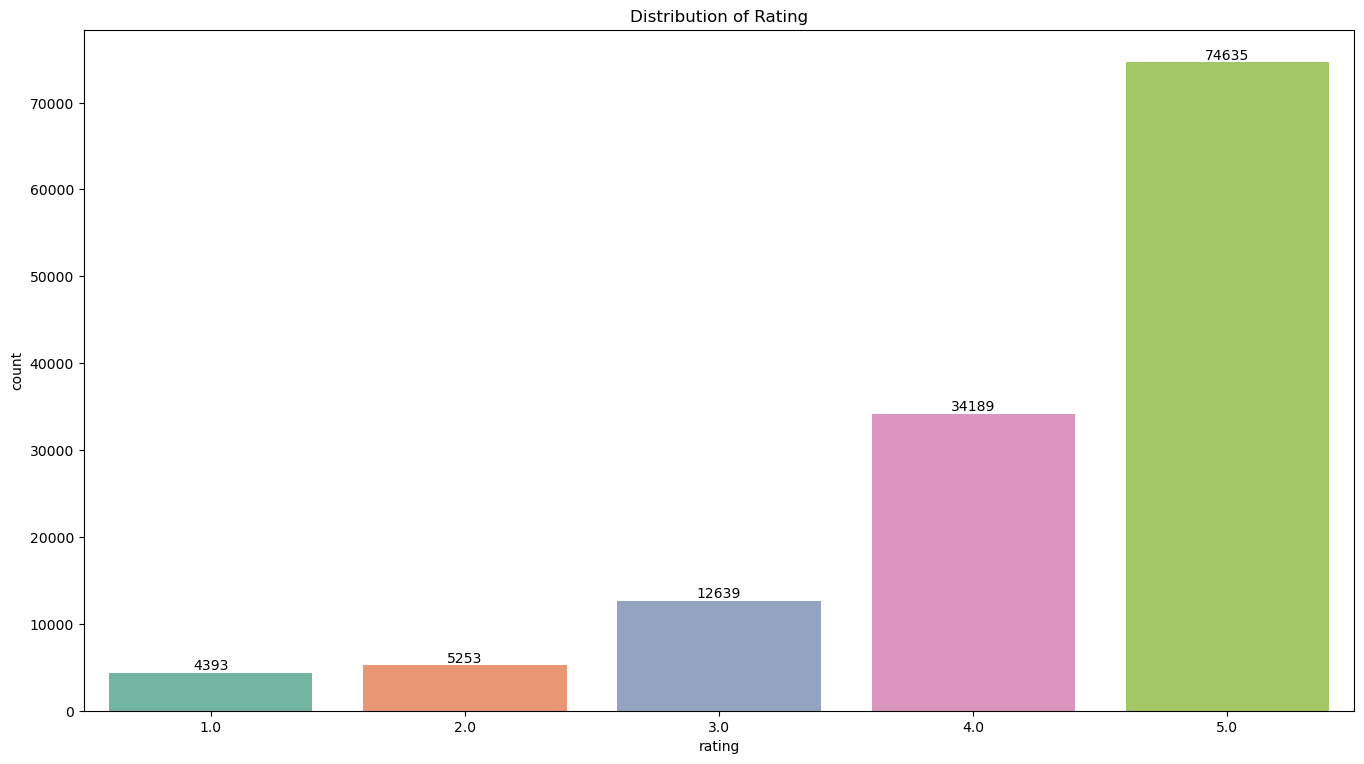

Mean: 4.29, Median: 5.0


In [132]:
# Visualizing the distribution of the feature 'rating' and relative percentage annotations
barplot(df, "rating", perc=False)

**Observations**:
- **High Ratings Dominance**: The majority of ratings are high, with 56.93% being 5.0 and 26.08% at 4.0, indicating a strong bias toward positive feedback.
- **Low Ratings Rarity**: Low ratings (1.0 and 2.0) are rare, accounting for only 3.35% and 4.01% of the ratings, respectively.
- **Left-Skewed Distribution**: The distribution is left-skewed, with the mean (4.29) being lower than the median (5.0).

### Univariate Analysis of Categorical Columns

#### Column | user_id, prod_id

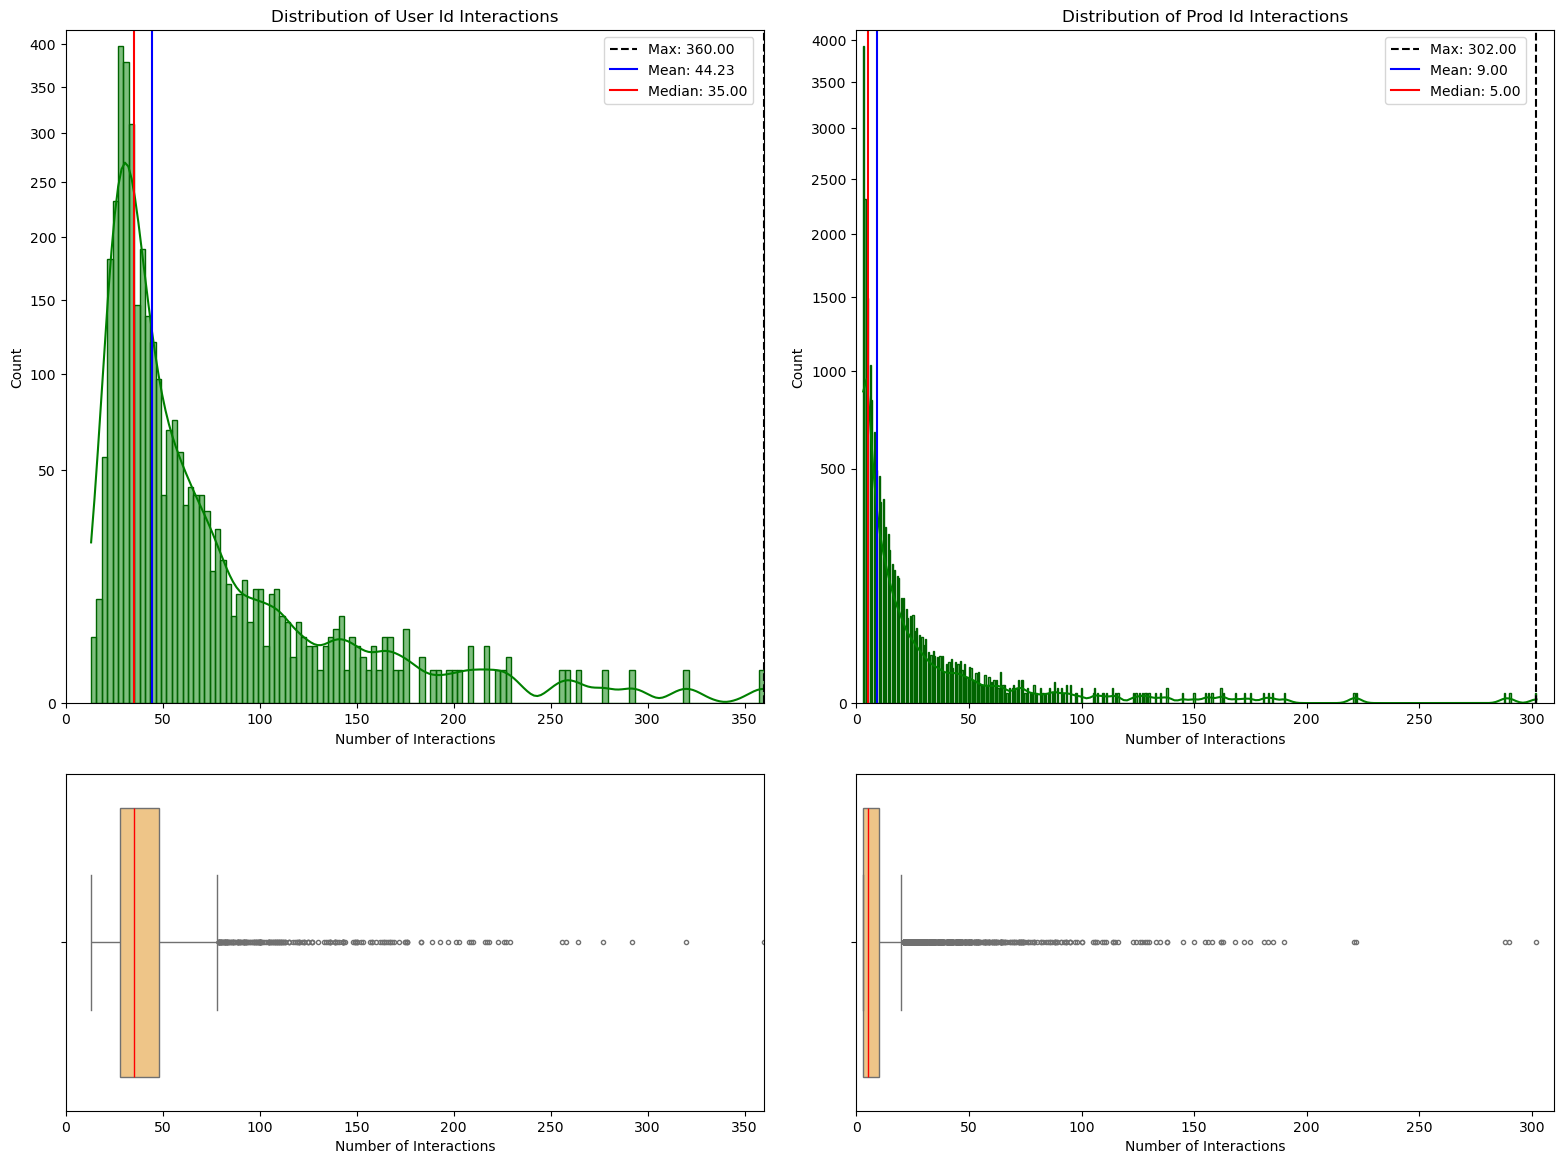

In [133]:
# Note: Histplot y-axis is scaled by square root

# Create a combined figure with GridSpec
fig = plt.figure(figsize=(16, 12))
gs = GridSpec(2, 2, height_ratios=[2, 1])

# Plotting user-product interactions distribution (histplot)
ax0 = fig.add_subplot(gs[0, 0])
plot_interaction_histplot(df, "user_id", "prod_id", ax0)

# Plotting product-user interactions distribution (histplot)
ax1 = fig.add_subplot(gs[0, 1])
plot_interaction_histplot(df, "prod_id", "user_id", ax1)

# Plotting user-product interactions distribution (boxplot)
ax2 = fig.add_subplot(gs[1, 0])
plot_interaction_boxplot(df, "user_id", "prod_id", ax2)

# Plotting product-user interactions distribution (boxplot)
ax3 = fig.add_subplot(gs[1, 1])
plot_interaction_boxplot(df, "prod_id", "user_id", ax3)

# Synchronize x-axis limits for boxplots
ax2.set_xlim(ax0.get_xlim()[0], ax0.get_xlim()[1])
ax3.set_xlim(ax0.get_xlim()[0], ax1.get_xlim()[1])

plt.tight_layout(pad=2.0)
plt.show()

**Observations**:

- **Skewed Distribution**: Both user-product and product-user interactions show a right-skewed distribution, with most interactions being on the lower end.
- **Low Interaction Dominance**: The majority of users interact with a small number of products (10 to 50 interactions), and most products are interacted with by a small number of users (1 to 10 interactions).
- **Presence of Outliers**: There are notable outliers, with the maximum interactions for a single user reaching 360 and for a single product reaching 302, significantly higher than the mean and median, indicating that very few products and users dominate the interaction counts.

#### Column | user_id

Top 10 Entries
------------------------------
       user_id  count
  ADLVFFE4VBT8    360
A3OXHLG6DIBRW8    320
A1ODOGXEYECQQ8    292
 A680RUE1FDO8B    277
A36K2N527TXXJN    264
  A6FIAB28IS79    258
A25C2M3QF9G7OQ    256
A22CW0ZHY3NJH8    229
 A5JLAU2ARJ0BO    227
 AWPODHOB4GFWL    226
------------------------------


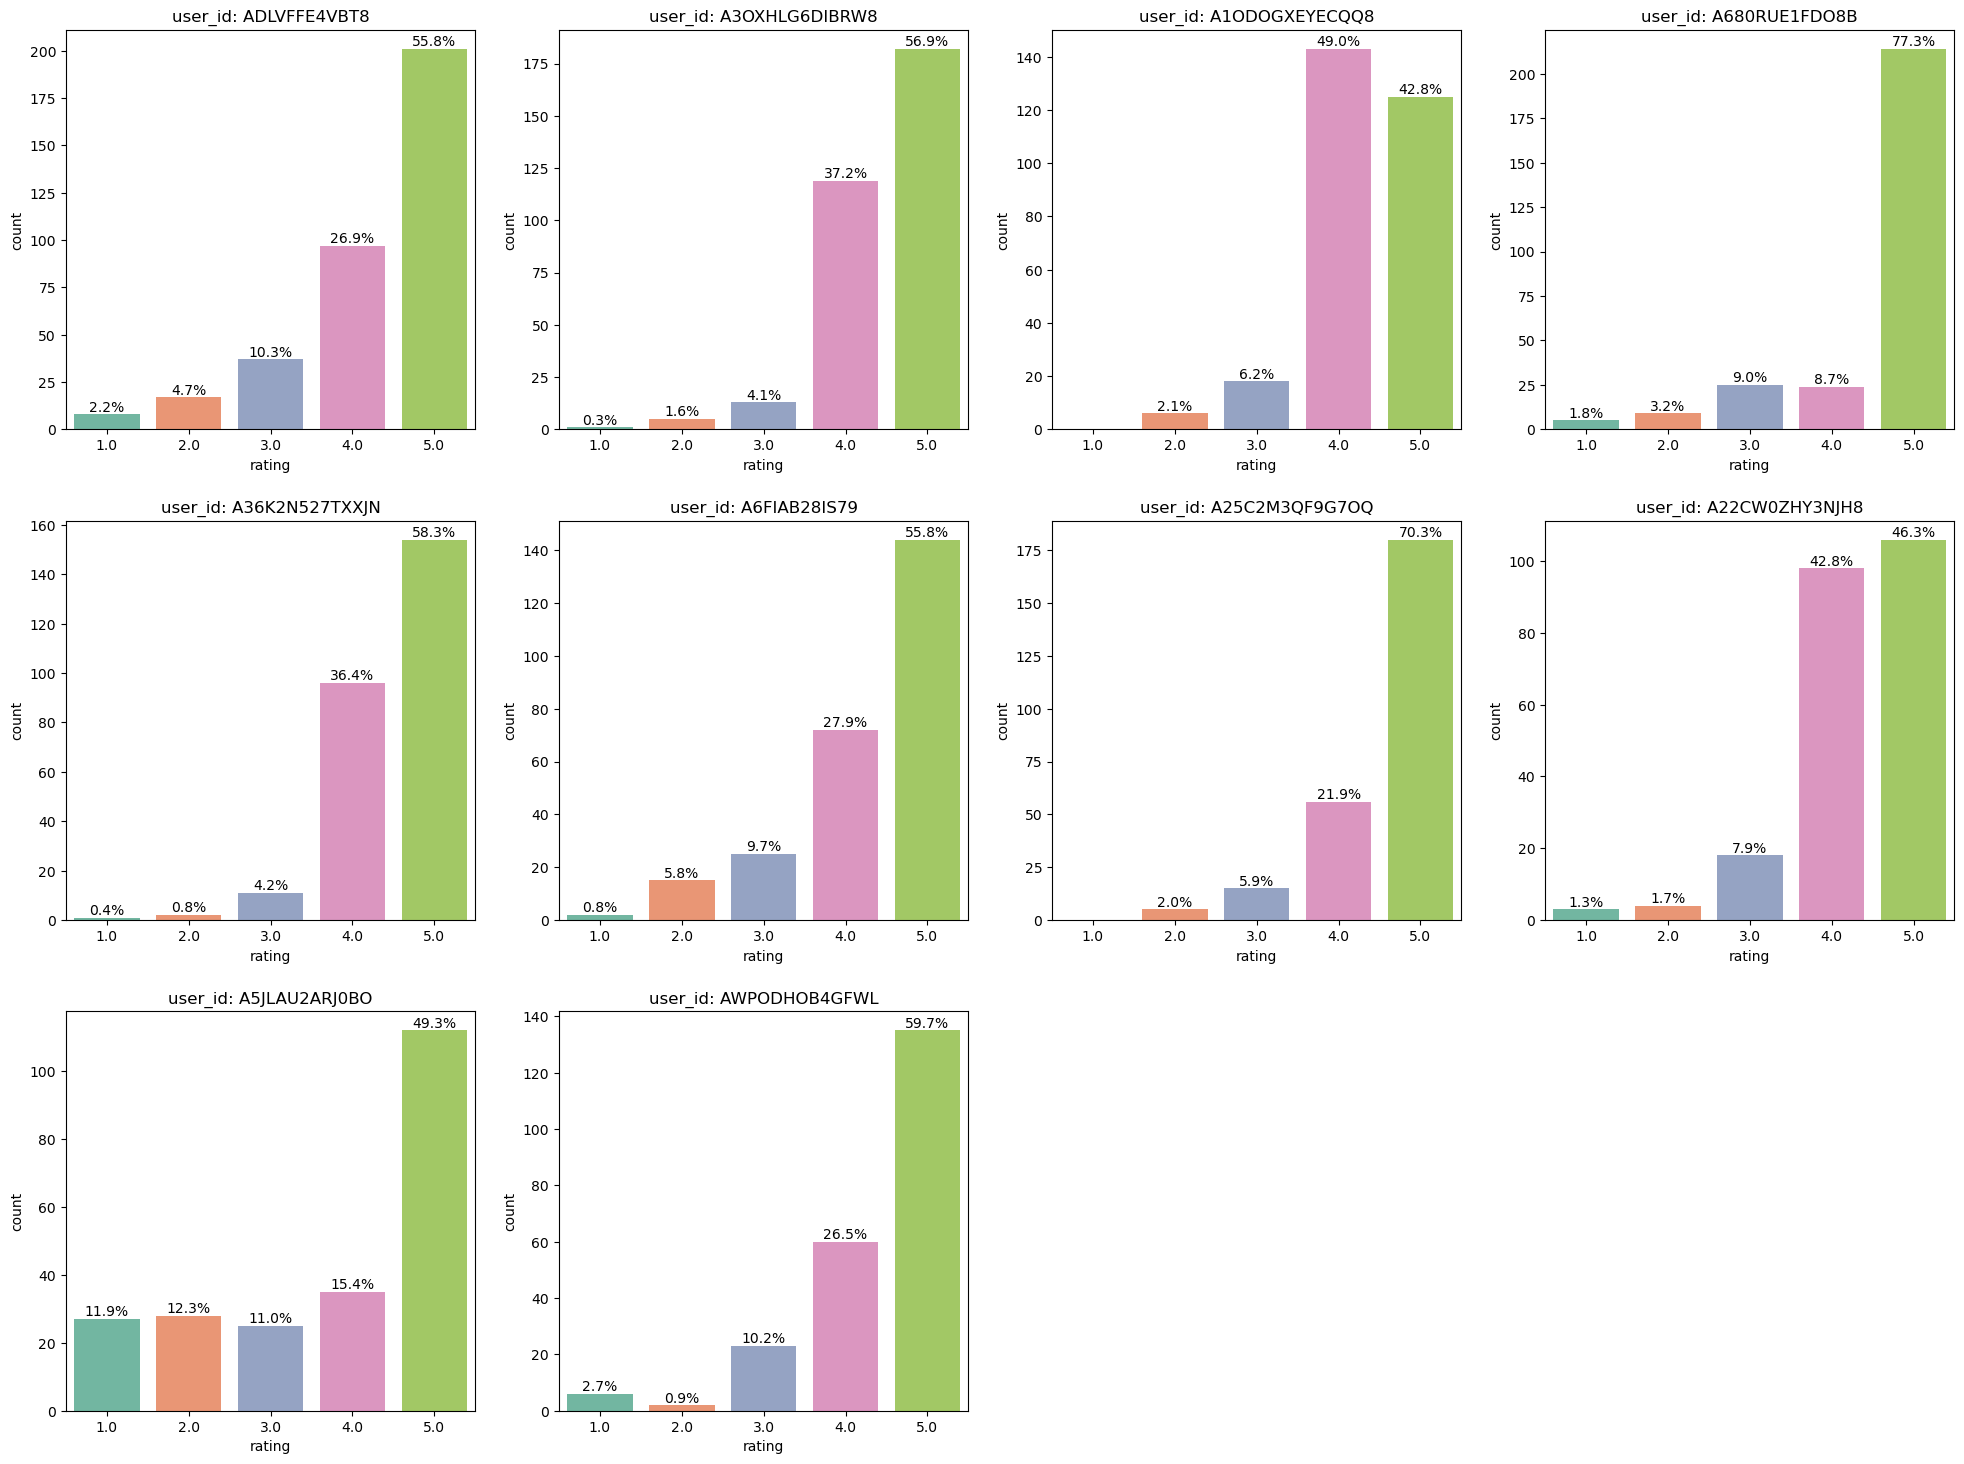

In [134]:
# Visualizing the rating distribution for the top 10 users based on the total number of ratings
features = ["user_id", "rating"]
barplot_subplots(df, features, perc=True)

**Observations**:
- **High User Engagement**: The most active user, 'ADLVFFE4VBT8', has 360 interactions, with other top users ranging from 240 to 320 interactions, indicating significant engagement from a small subset of users.
- **Positive Rating Dominance**: The majority of top users consistently favor 5-star ratings, with percentages between 46.3% and 77.3%, reflecting a strong tendency toward positive feedback.
- **Diverse and Consistent Rating Behavior**: While most users predominantly give 5-star ratings, some, like 'ADLVFFE4VBT8', 'AWPODHOB4GFWL' and 'A5JLAU2ARJ0BO', show a more varied rating distribution with significant 3-star and 4-star ratings, suggesting varying levels of satisfaction or rating behavior among the most active users.
- **Rare Negative Ratings**: Low ratings (1 and 2 stars) are infrequent among the top 10 users, averaging 2.14% and 3.51% respectively, indicating generally positive experiences or a reluctance to rate poorly.

#### Column | prod_id

Top 10 Entries
------------------------------
   prod_id  count
B0088CJT4U    302
B003ES5ZUU    290
B007WTAJTO    288
B000N99BBC    222
B00829TIEK    221
B002V88HFE    190
B009SYZ8OC    185
B00829THK0    183
B008DWCRQW    181
B002WE6D44    175
------------------------------


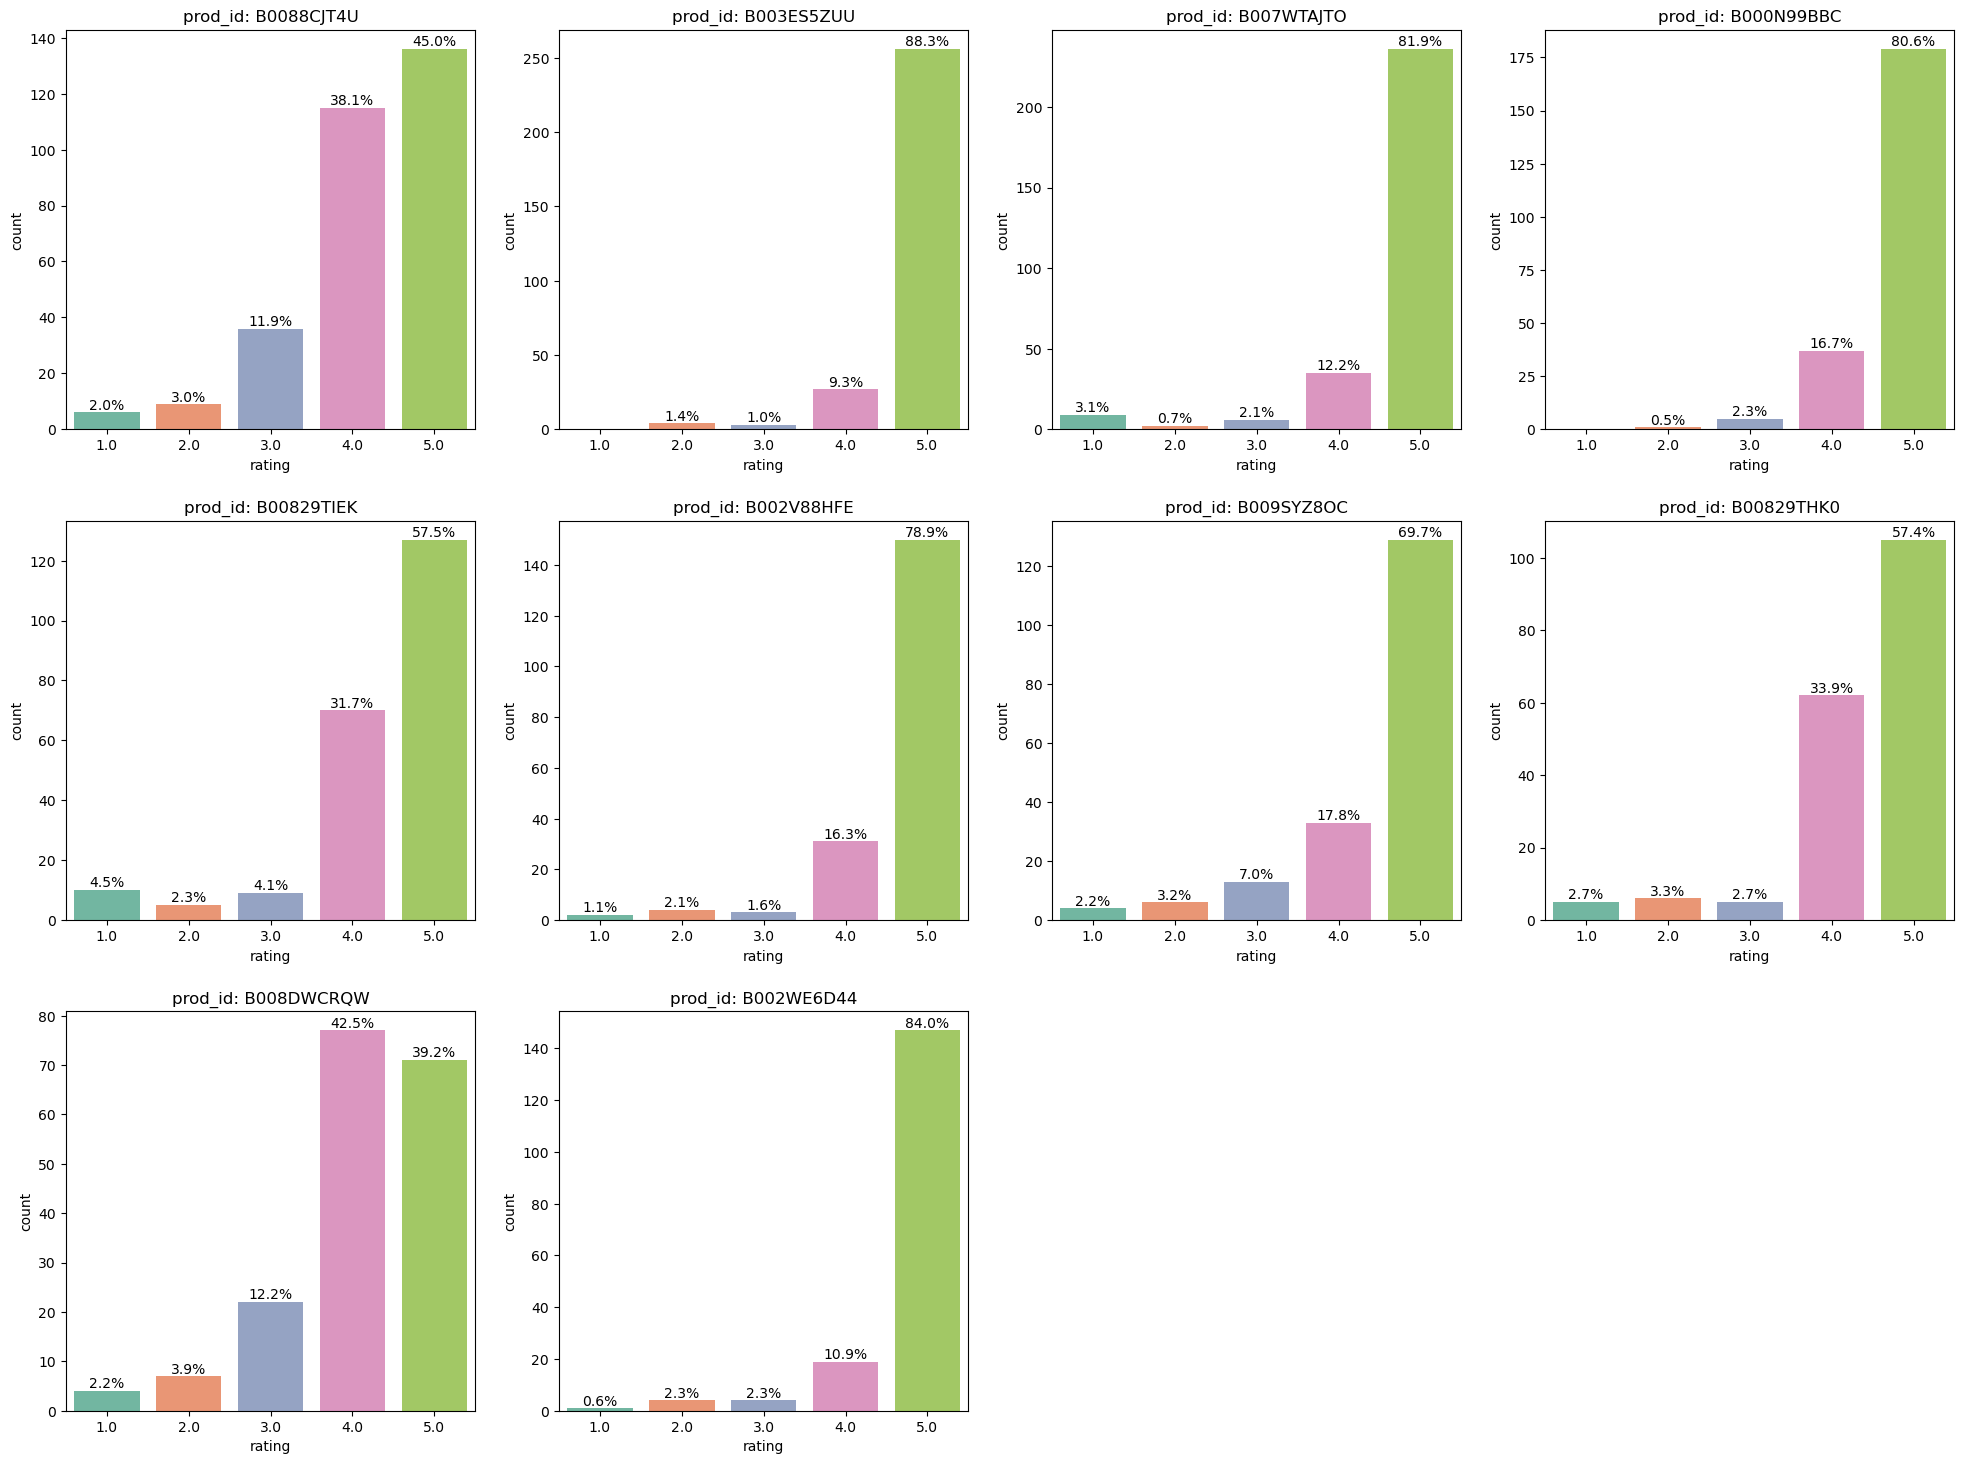

In [135]:
# Visualizing the rating distribution for the top 10 products based on the total number of ratings
features = ["prod_id", "rating"]
barplot_subplots(df, features, perc=True)

**Observations**:
- **Top Products by Interaction**: The most frequently rated product, 'B0088CJT4U', has 302 ratings, with others in the top 10 ranging from 290 to 175 ratings, indicating significant engagement with a small subset of products.
- **Positive Rating Dominance**: The majority of the top products exhibit a strong tendency toward 5-star ratings, with percentages ranging from 45.0% to 88.3%. This reflects a generally positive feedback pattern.
- **Diverse Rating Behavior**: While high ratings are dominant, products like 'B008DWCRQW', 'B00829TIEK', and 'B0088CJT4U' display a wider spread across different rating levels, with notable proportions of 3-star and 4-star ratings, indicating more varied customer experiences.
- **Low Frequency of Negative Ratings**: Across these top 10 products, ratings of 1 and 2 stars are rare, averaging around 1.84% and 2.27% respectively, suggesting generally positive experiences or a reluctance to rate products poorly.

---

In [136]:
# Defining a function to get the top n products based on the highest average rating and minimum interactions
def top_n_products(data, n, threshold=0):

    # Finding products with minimum number of interactions
    recommendations = data[data["cnt_rating"] > threshold]

    # Sorting values with respect to average rating
    recommendations = recommendations.sort_values(
        by=["bayesian_avg"], ascending=[False]
    )

    # Get the top n products
    return recommendations["bayesian_avg"].nlargest(n).round(2).reset_index()

## Model 1: Rank Based Recommendation System

A rank-based recommendation system provides recommendations based on the most popular items. This approach is useful for addressing cold start problems, where new users lack historical interactions. In such cases, the system can recommend popular items to new users without relying on past data.

The **Bayesian Average** enhances the reliability of a product’s rating by considering both the global average rating and the number of ratings a product has received. This method reduces the impact of small sample sizes, ensuring fairer recommendations by preventing products with few ratings from being overly favored or penalized.

$$\text{Bayesian Avg.} = \frac{\bar{R} \times k + \sum R}{k + N}$$

where:
- $\bar{R}$ is the global average rating.
- $k$ is the regularization parameter (often set to the average number of ratings across items).
- $\sum R$ is the sum of ratings for the specific item.
- $N$ is the number of ratings for the specific item.

### Baseline | Rank Based Recommendation System

In [137]:
# Get the count of ratings and average of ratings for each product
prod_stats = df.groupby("prod_id")["rating"].agg(["mean", "count"])

# Rename columns
prod_stats = prod_stats.rename(columns={"mean": "avg_rating", "count": "cnt_rating"})

# Define the global mean (average rating across all products)
global_rating = df["rating"].mean()

# Set the hyperparameter (average number of ratings across all products)
k = prod_stats["cnt_rating"].mean()

# Calculate the Bayesian Average for each product using existing columns
prod_stats["bayesian_avg"] = (
    global_rating * k + prod_stats["cnt_rating"] * prod_stats["avg_rating"]
) / (k + prod_stats["cnt_rating"])

# Sort the dataframe by average of ratings in the descending order
prod_stats = prod_stats.sort_values(by=["bayesian_avg"], ascending=[False])

### Model Recommendation

In [138]:
# Retrieve the top 10 products, ranked using the Bayesian average
top_n_products(prod_stats, 10)

,prod_id,bayesian_avg
0,B0052SCU8U,4.91
1,B001TH7GUU,4.85
2,B007SZ0E1K,4.84
3,B003FVJYF8,4.83
4,B003ES5ZUU,4.83
5,B001TH7T2U,4.81
6,B00316263Y,4.81
7,B00HG1L334,4.81
8,B005LDLP8W,4.81
9,B001TH7GSW,4.80


In [139]:
# Retrieve the top 10 products with at least 50 interactions, ranked using the Bayesian average
top_n_products(prod_stats, 10, 50)

,prod_id,bayesian_avg
0,B0052SCU8U,4.91
1,B001TH7GUU,4.85
2,B003ES5ZUU,4.83
3,B001TH7T2U,4.81
4,B00316263Y,4.81
5,B001TH7GSW,4.80
6,B0000BZL1P,4.79
7,B00BQ4F9ZA,4.78
8,B00E3W15P0,4.77
9,B0019EHU8G,4.76


**Observations**:
- The rank-based recommendation system identifies the top 10 products from the prepared dataset, utilizing the Bayesian average to balance popularity with the number of interactions. Additionally, the system refines the rankings by considering products with at least 50 interactions, ensuring a more robust and fair product ranking.

## Model 2: User-User Collaborative Filtering Recommendation System

### Defintion of Functions

In [140]:
def calculate_predictive_metrics(user_est_true, k=10, threshold=3.5):
    """
    Calculate predictive quality metrics for a recommendation model, including Precision@K, Recall@K, and F1 Score@K.

    Parameters:
    - user_est_true: Dictionary mapping user IDs to a list of (estimated rating, true rating) tuples.
    - k: The number of top recommendations to consider (default is 10).
    - threshold: The rating threshold to consider an item as relevant (default is 3.5).

    Returns:
    - A dictionary containing:
      - Precision@K: The proportion of recommended items in the top K that are relevant.
      - Recall@K: The proportion of relevant items that are recommended in the top K.
      - F1 Score@K: The harmonic mean of Precision@K and Recall@K.
    """

    # Initialize dictionaries to store precision and recall for each user
    precisions = {}
    recalls = {}

    # Recall@K: Proportion of relevant items that are recommended (0 if n_rel is 0)
    # Precision@K: Proportion of recommended items that are relevant (0 if n_rec_k is 0)

    for uid, user_ratings in user_est_true.items():
        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for _, true_r in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for est, _ in user_ratings[:k])
        n_rel_and_rec_k = sum(
            ((true_r >= threshold) and (est >= threshold))
            for est, true_r in user_ratings[:k]
        )

        # Calculate Precision@K for the user
        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Calculate Recall@K for the user
        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    # Calculate the average of Precision@K and Recall@K
    precision = round(sum(prec for prec in precisions.values()) / len(precisions), 3)
    recall = round(sum(rec for rec in recalls.values()) / len(recalls), 3)

    # Calculate F1 Score@K
    f1 = (
        round((2 * precision * recall) / (precision + recall), 3)
        if (precision + recall) != 0
        else 0
    )

    # Return all scores in a dictionary
    return {
        "Precision@K": precision,
        "Recall@K": recall,
        "F1 Score@K": f1,
    }

In [141]:
def calculate_ranking_metrics(user_est_true, k=10, threshold=3.5):
    """
    Calculate the ranking quality metrics for a recommendation model, including MRR, MAP, and Hit Rate@K.

    Parameters:
    - user_est_true: Dictionary mapping user IDs to a list of (estimated rating, true rating) tuples.
    - k: The number of top recommendations to consider (default is 10).
    - threshold: The rating threshold to consider an item as relevant (default is 3.5).

    Returns:
    - A dictionary containing:
      - MRR: Mean Reciprocal Rank, the average rank of the first relevant item for each user.
      - MAP: Mean Average Precision, the average of the precision scores for all relevant items.
      - Hit Rate@K: The proportion of users for whom at least one relevant item appears in the top K recommendations.
    """

    # Initialize sums for MRR, MAP, and count for Hit Rate
    mrr_sum = 0
    map_sum = 0
    hit_rate_count = 0

    # Get the total number of users
    num_users = len(user_est_true)

    for uid, user_ratings in user_est_true.items():
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Calculate MRR for the user
        for rank, (est, true_r) in enumerate(user_ratings[:k], start=1):
            if true_r >= threshold:
                mrr_sum += 1 / rank
                break

        # Calculate MAP for the user
        hits = 0
        avg_precision = 0
        for rank, (est, true_r) in enumerate(user_ratings[:k], start=1):
            if true_r >= threshold:
                hits += 1
                avg_precision += hits / rank

        if hits > 0:
            map_sum += avg_precision / hits

        # Calculate Hit Rate for the user
        if hits > 0:
            hit_rate_count += 1

    # Calculate the average of all metrics
    mrr = round(mrr_sum / num_users, 3)
    map_score = round(map_sum / num_users, 3)
    hit_rate = round(hit_rate_count / num_users, 3)

    # Return all scores in a dictionary
    return {
        "MRR": mrr,
        "MAP": map_score,
        "Hit Rate@K": hit_rate,
    }

In [142]:
def evaluate_model(predictions, k=10, threshold=3.5):
    """
    Evaluate a recommendation model using both predictive quality metrics (RMSE, Precision@K, Recall@K, F1 Score@K)
    and ranking quality metrics (MRR, MAP, Hit Rate@K).

    Parameters:
    - predictions: List of predictions made by the recommendation model.
    - k: The number of top recommendations to consider (default is 10).
    - threshold: The rating threshold to consider an item as relevant (default is 3.5).

    Returns:
    - A dictionary containing:
      - RMSE: Root Mean Square Error, a measure of the differences between predicted and actual ratings.
      - Precision@K: The proportion of recommended items in the top K that are relevant.
      - Recall@K: The proportion of relevant items that are recommended in the top K.
      - F1 Score@K: The harmonic mean of Precision@K and Recall@K.
      - MRR: Mean Reciprocal Rank, the average rank of the first relevant item for each user.
      - MAP: Mean Average Precision, the average of the precision scores for all relevant items.
      - Hit Rate@K: The proportion of users for whom at least one relevant item appears in the top K.

    The function prints and aggregates both predictive and ranking metrics to provide a comprehensive evaluation.
    """

    # Calculate RMSE directly from predictions
    rmse = round(accuracy.rmse(predictions, verbose=False), 3)

    # Initialize a dictionary to store the estimated and true ratings for each user
    user_est_true = defaultdict(list)

    # Populate the dictionary with predictions: mapping user ID to a list of (estimated rating, true rating) tuples
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    # Calculate predictive quality metrics (Precision@K, Recall@K, F1 Score@K)
    predictive_metrics = calculate_predictive_metrics(user_est_true, k, threshold)

    # Add RMSE to the predictive metrics
    predictive_metrics = {"RMSE": rmse, **predictive_metrics}

    # Calculate ranking quality metrics (MRR, MAP, Hit Rate@K)
    ranking_metrics = calculate_ranking_metrics(user_est_true, k, threshold)

    # Print the predictive quality metrics
    display(Markdown(f"**Predictive Quality Metrics**"))
    for metric, value in predictive_metrics.items():
        print(f"{metric}: {value}")

    # Print the ranking quality metrics
    display(Markdown(f"**Ranking Quality Metrics**"))
    for metric, value in ranking_metrics.items():
        print(f"{metric}: {value}")

    # Combine the results
    combined_metrics = {**ranking_metrics, **predictive_metrics}

    # Return all scores
    return combined_metrics

In [143]:
def get_recommendations(data, user_id, top_n, algo):
    """
    This function recommends top_n products for a given user based on the specified algorithm.

    Parameters:
    - data: A rating dataset
    - user_id: The user id for which recommendations are needed
    - top_n: The number of products to recommend
    - algo: The algorithm to use for predicting ratings

    Output:
    - A set of top_n items recommended for the given user_id based on the given algorithm
    """

    # Creating an empty list to store the recommended product ids
    recommendations = []

    # Creating an user item interactions matrix
    user_item_interactions_matrix = data.pivot(
        index="user_id", columns="prod_id", values="rating"
    )

    # Extracting those product ids which the user_id has not interacted yet
    non_interacted_products = user_item_interactions_matrix.loc[user_id][
        user_item_interactions_matrix.loc[user_id].isnull()
    ].index.tolist()

    # Looping through each of the product ids which user_id has not interacted yet
    for item_id in non_interacted_products:

        # Predicting the ratings for those non interacted product ids by this user
        est = algo.predict(user_id, item_id).est
        details = algo.predict(user_id, item_id).details

        # Appending the predicted ratings
        recommendations.append((item_id, est, details))

    # Sorting the predicted ratings in descending order
    recommendations.sort(key=lambda x: x[1], reverse=True)

    # Convert recommendations to DataFrame and round predicted ratings
    recommendations_df = pd.DataFrame(
        recommendations[:top_n],
        columns=["prod_id", "estimated_ratings", "details"],
    ).assign(estimated_ratings=lambda df: df["estimated_ratings"].round(2))

    # Returing top n highest predicted rating products for this user
    return recommendations_df

### Data Preprocessing

Loading the **rating dataset**, a pandas DataFrame, into a different format called **'surprise.dataset.DatasetAutoFolds'**, which is required by the 'surprise' library. This process uses the **'Reader' and 'Dataset' classes**.

In [144]:
def select_interactions(trainset, num_users=2, num_products=2, seed=42):

    # Set the random seed for reproducibility
    random.seed(seed)

    # Randomly select a few users from the trainset
    random_inner_uids = random.sample(trainset.all_users(), num_users)

    # Initialize dictionaries to store user interactions and all interacted products
    user_interactions = {}
    user_interacted_products = {}
    user_non_interactions = {}  # If you plan to use this later

    # Get the set of all product IDs in the trainset
    all_products = set(trainset.to_raw_iid(item) for item in trainset.all_items())

    # Iterate over the selected users in the trainset
    for inner_uid in random_inner_uids:
        # Convert inner user ID to raw user ID
        raw_user_id = trainset.to_raw_uid(inner_uid)

        # Get the list of (item_inner_id, rating) tuples for this user
        user_ratings = trainset.ur[inner_uid]

        # Convert item_inner_id to raw item IDs and store the interactions
        user_interacted_products[raw_user_id] = [
            (trainset.to_raw_iid(item_inner_id), rating)
            for item_inner_id, rating in user_ratings
        ]

        # Randomly select a few interacted products
        user_interactions[raw_user_id] = random.sample(
            user_interacted_products[raw_user_id], num_products
        )

        # Get the set of interacted product IDs for the current user
        interacted_products = set(
            item_id for item_id, _ in user_interacted_products[raw_user_id]
        )

        # Identify non-interacted products by subtracting interacted ones from all products
        non_interacted_products = list(all_products - interacted_products)

        # Randomly select non-interacted products
        if len(non_interacted_products) >= num_products:
            user_non_interactions[raw_user_id] = random.sample(
                non_interacted_products, num_products
            )

    return user_interactions, user_non_interactions

In [145]:
# Instantiating Reader scale with expected rating scale
reader = Reader(rating_scale=(0, 5))

# Loading the rating dataset
data = Dataset.load_from_df(df[["user_id", "prod_id", "rating"]], reader=reader)

# Splitting the data into train and test datasets
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

# Randomly select user IDs and retrieve their interacted and non-interacted products
user_interactions, user_non_interactions = select_interactions(
    trainset, num_users=2, num_products=2
)

In [146]:
# Example usage
print("Interacted Products with Ratings:")
print(user_interactions)
print("\nNon-Interacted Products:")
print(user_non_interactions)

Interacted Products with Ratings:
{'A3HPCRD9RX351S': [('B00B3YQGHS', 5.0), ('B007Y4NWQE', 5.0)], 'A2GL934UT3XENH': [('B009LPV766', 5.0), ('B00HPM1FZ0', 5.0)]}

Non-Interacted Products:
{'A3HPCRD9RX351S': ['B004ETQHV4', 'B00IDYS0XY'], 'A2GL934UT3XENH': ['B003LWTL2C', 'B005450ZUG']}


In [147]:
class RecommendationSystem:
    def __init__(
        self,
        data: pd.DataFrame,
        algo_class,
        sim_options: dict = None,
        random_state: int = 42,
    ):
        self.data = data
        self.algo_class = algo_class
        self.sim_options = sim_options
        self.random_state = random_state
        self.model = None
        self.best_params = None
        self.gs = None
        self.predictions = None
        self.model_metrics = None

    def fit_knn(self, trainset, use_tuned_params: bool = False) -> None:
        if self.algo_class not in (KNNBasic, KNNBaseline, KNNWithMeans, KNNWithZScore):
            raise ValueError(
                "The algo_class is not kNN inspired. Please use select different algo_class."
            )
        if use_tuned_params and self.best_params is not None:
            model_params = {
                "k": self.best_params.get("k", 40),
                "min_k": self.best_params.get("min_k", 1),
                "sim_options": self.best_params.get("sim_options", self.sim_options),
                "random_state": self.random_state,
                "verbose": False,
            }
        else:
            model_params = {
                "sim_options": self.sim_options,
                "random_state": self.random_state,
                "verbose": False,
            }

        self.model = self.algo_class(**model_params)
        self.model.fit(trainset)

    def fit_svd(self, trainset, use_tuned_params: bool = False) -> None:
        if self.algo_class not in (SVD, SVDpp):
            raise ValueError("The algo_class is not SVD. Please use fit_knn.")

        if use_tuned_params and self.best_params is not None:
            model_params = {
                "n_factors": self.best_params.get("n_factor", 100),
                "n_epochs": self.best_params.get("n_epochs", 20),
                "lr_all": self.best_params.get("lr_all", 0.005),
                "reg_all": self.best_params.get("reg_all", 0.02),
                "random_state": self.random_state,
            }
        else:
            model_params = {
                "random_state": self.random_state,
            }

        self.model = self.algo_class(**model_params)
        self.model.fit(trainset)

    def evaluate(self, testset, k: int = 10, th: float = 3.5) -> dict:
        self.predictions = self.model.test(testset)
        self.model_metrics = evaluate_model(self.predictions, k=k, threshold=th)
        return self.model_metrics

    def predict(self, data: dict, has_interacted: bool) -> None:
        phrase = "" if has_interacted else "Non-"

        # Print the header
        display(Markdown(f"**Rating Estimates for {phrase}Interacted Products**"))

        for user, interactions in data.items():
            for interaction in interactions:
                if has_interacted:
                    iid, rui = interaction  # product ID, rating
                    pred = self.model.predict(
                        uid=user, iid=iid, r_ui=rui, verbose=False
                    )
                else:
                    iid = interaction  # product ID
                    pred = self.model.predict(uid=user, iid=iid, verbose=False)
                print(pred)

    def tune_hyperparameters(
        self, param_grid: dict, measure: list = ["rmse"], cv: int = 6
    ) -> None:
        self.gs = GridSearchCV(
            self.algo_class, param_grid=param_grid, measures=measure, cv=cv, n_jobs=-1
        )
        self.gs.fit(self.data)
        self.best_score = self.gs.best_score[measure[0]]
        self.best_params = self.gs.best_params[measure[0]]

        # Best RMSE score
        print(f"{measure[0].upper()}: {self.best_score.round(3)}")
        print(f"Parameters: {self.best_params}")

    def recommend(self, data: pd.DataFrame, int_data: dict) -> None:
        if self.model is None:
            raise ValueError("Model is not trained.")

        for user in int_data.keys():
            recommendations = get_recommendations(
                data=data, user_id=user, top_n=5, algo=self.model
            )
            display(Markdown(f"**Recommendations for User: {user}**"))
            display(recommendations)

In [148]:
sim_options = {"name": "pearson_baseline", "user_based": True}
model = KNNBaseline
k = 10
threshold = 4.5

model_uu = RecommendationSystem(data=data, algo_class=model, sim_options=sim_options)

In [149]:
model_uu.fit_knn(trainset=trainset, use_tuned_params=False)
model_uu_metric = model_uu.evaluate(testset=testset, k=k, th=threshold)

**Predictive Quality Metrics**

RMSE: 1.009
Precision@K: 0.565
Recall@K: 0.409
F1 Score@K: 0.475


**Ranking Quality Metrics**

MRR: 0.788
MAP: 0.739
Hit Rate@K: 0.961


In [150]:
model_uu.predict(data=user_interactions, has_interacted=True)
model_uu.predict(data=user_non_interactions, has_interacted=False)

**Rating Estimates for Interacted Products**

user: A3HPCRD9RX351S item: B00B3YQGHS r_ui = 5.00   est = 4.99   {'actual_k': 8, 'was_impossible': False}
user: A3HPCRD9RX351S item: B007Y4NWQE r_ui = 5.00   est = 5.00   {'actual_k': 2, 'was_impossible': False}
user: A2GL934UT3XENH item: B009LPV766 r_ui = 5.00   est = 5.00   {'actual_k': 4, 'was_impossible': False}
user: A2GL934UT3XENH item: B00HPM1FZ0 r_ui = 5.00   est = 4.99   {'actual_k': 12, 'was_impossible': False}


**Rating Estimates for Non-Interacted Products**

user: A3HPCRD9RX351S item: B004ETQHV4 r_ui = None   est = 4.49   {'actual_k': 0, 'was_impossible': False}
user: A3HPCRD9RX351S item: B00IDYS0XY r_ui = None   est = 4.40   {'actual_k': 0, 'was_impossible': False}
user: A2GL934UT3XENH item: B003LWTL2C r_ui = None   est = 4.59   {'actual_k': 0, 'was_impossible': False}
user: A2GL934UT3XENH item: B005450ZUG r_ui = None   est = 4.82   {'actual_k': 2, 'was_impossible': False}


In [151]:
# Setting up parameter grid to tune the hyperparameters
param_grid = {
    "k": [10, 20, 30, 40],
    "min_k": [1, 3, 5],
    "sim_options": {
        "name": ["msd", "cosine", "pearson_baseline"],
        "user_based": [True],
    },
}

model_uu.tune_hyperparameters(param_grid=param_grid, measure=["rmse"], cv=6)

Estimating biases using als...
Computing the msd similarity matrix...
Estimating biases using als...
Computing the msd similarity matrix...
Estimating biases using als...
Done computing similarity matrix.
Computing the msd similarity matrix...
Estimating biases using als...
Done computing similarity matrix.
Computing the msd similarity matrix...
Estimating biases using als...
Done computing similarity matrix.
Computing the msd similarity matrix...
Estimating biases using als...
Done computing similarity matrix.
Computing the msd similarity matrix...
Estimating biases using als...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Estimating biases using als...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Estimating biases using als...
Computing the cosine similarity matrix...
Estimating biases using als...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Estimating biases using als...
Done computing simi

In [152]:
model_uu.fit_knn(trainset=trainset, use_tuned_params=True)
model_uu_opt_metric = model_uu.evaluate(testset=testset, k=k, th=threshold)

**Predictive Quality Metrics**

RMSE: 0.934
Precision@K: 0.51
Recall@K: 0.345
F1 Score@K: 0.412


**Ranking Quality Metrics**

MRR: 0.815
MAP: 0.756
Hit Rate@K: 0.96


In [153]:
model_uu.predict(data=user_interactions, has_interacted=True)
model_uu.predict(data=user_non_interactions, has_interacted=False)

**Rating Estimates for Interacted Products**

user: A3HPCRD9RX351S item: B00B3YQGHS r_ui = 5.00   est = 4.99   {'actual_k': 8, 'was_impossible': False}
user: A3HPCRD9RX351S item: B007Y4NWQE r_ui = 5.00   est = 4.38   {'actual_k': 2, 'was_impossible': False}
user: A2GL934UT3XENH item: B009LPV766 r_ui = 5.00   est = 4.70   {'actual_k': 4, 'was_impossible': False}
user: A2GL934UT3XENH item: B00HPM1FZ0 r_ui = 5.00   est = 4.99   {'actual_k': 12, 'was_impossible': False}


**Rating Estimates for Non-Interacted Products**

user: A3HPCRD9RX351S item: B004ETQHV4 r_ui = None   est = 4.49   {'actual_k': 0, 'was_impossible': False}
user: A3HPCRD9RX351S item: B00IDYS0XY r_ui = None   est = 4.40   {'actual_k': 0, 'was_impossible': False}
user: A2GL934UT3XENH item: B003LWTL2C r_ui = None   est = 4.59   {'actual_k': 0, 'was_impossible': False}
user: A2GL934UT3XENH item: B005450ZUG r_ui = None   est = 4.69   {'actual_k': 2, 'was_impossible': False}


In [154]:
model_uu.recommend(data=df, int_data=user_interactions)

**Recommendations for User: A3HPCRD9RX351S**

,prod_id,estimated_ratings,details
0,B002WE4HE2,5.00,"{'actual_k': 5, 'was_impossible': False}"
1,B00834SJSK,5.00,"{'actual_k': 5, 'was_impossible': False}"
2,B00DTZYHX4,5.00,"{'actual_k': 6, 'was_impossible': False}"
3,B00A35WYBA,4.97,"{'actual_k': 5, 'was_impossible': False}"
4,B00DK2JQOQ,4.96,"{'actual_k': 5, 'was_impossible': False}"


**Recommendations for User: A2GL934UT3XENH**

,prod_id,estimated_ratings,details
0,B00006HSML,5,"{'actual_k': 0, 'was_impossible': False}"
1,B00007GQLS,5,"{'actual_k': 0, 'was_impossible': False}"
2,B000089GN3,5,"{'actual_k': 1, 'was_impossible': False}"
3,B00009R6WO,5,"{'actual_k': 0, 'was_impossible': False}"
4,B0000BZL1P,5,"{'actual_k': 0, 'was_impossible': False}"


## Model 3: Item-Item Collaborative Filtering Recommendation System

In [155]:
sim_options = {"name": "pearson_baseline", "user_based": False}
model = KNNBaseline

model_ii = RecommendationSystem(data=data, algo_class=model, sim_options=sim_options)

In [156]:
model_ii.fit_knn(trainset=trainset, use_tuned_params=False)
model_ii_metric = model_ii.evaluate(testset=testset, k=k, th=threshold)

**Predictive Quality Metrics**

RMSE: 1.004
Precision@K: 0.557
Recall@K: 0.401
F1 Score@K: 0.466


**Ranking Quality Metrics**

MRR: 0.793
MAP: 0.737
Hit Rate@K: 0.96


In [157]:
model_ii.predict(data=user_interactions, has_interacted=True)
model_ii.predict(data=user_non_interactions, has_interacted=False)

**Rating Estimates for Interacted Products**

user: A3HPCRD9RX351S item: B00B3YQGHS r_ui = 5.00   est = 5.00   {'actual_k': 10, 'was_impossible': False}
user: A3HPCRD9RX351S item: B007Y4NWQE r_ui = 5.00   est = 5.00   {'actual_k': 1, 'was_impossible': False}
user: A2GL934UT3XENH item: B009LPV766 r_ui = 5.00   est = 5.00   {'actual_k': 8, 'was_impossible': False}
user: A2GL934UT3XENH item: B00HPM1FZ0 r_ui = 5.00   est = 4.96   {'actual_k': 11, 'was_impossible': False}


**Rating Estimates for Non-Interacted Products**

user: A3HPCRD9RX351S item: B004ETQHV4 r_ui = None   est = 4.49   {'actual_k': 0, 'was_impossible': False}
user: A3HPCRD9RX351S item: B00IDYS0XY r_ui = None   est = 4.40   {'actual_k': 0, 'was_impossible': False}
user: A2GL934UT3XENH item: B003LWTL2C r_ui = None   est = 4.59   {'actual_k': 0, 'was_impossible': False}
user: A2GL934UT3XENH item: B005450ZUG r_ui = None   est = 4.90   {'actual_k': 2, 'was_impossible': False}


In [158]:
# Setting up parameter grid to tune the hyperparameters
param_grid = {
    "k": [10, 20, 30, 40],
    "min_k": [1, 3, 5],
    "sim_options": {
        "name": ["pearson_baseline"],
        "user_based": [False],
    },
}

model_ii.tune_hyperparameters(param_grid=param_grid, measure=["rmse"], cv=3)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done

In [159]:
model_ii.fit_knn(trainset=trainset, use_tuned_params=True)
model_ii_opt_metric = model_ii.evaluate(testset=testset, k=k, th=threshold)

**Predictive Quality Metrics**

RMSE: 0.934
Precision@K: 0.511
Recall@K: 0.344
F1 Score@K: 0.411


**Ranking Quality Metrics**

MRR: 0.818
MAP: 0.757
Hit Rate@K: 0.96


In [160]:
model_ii.predict(data=user_interactions, has_interacted=True)
model_ii.predict(data=user_non_interactions, has_interacted=False)

**Rating Estimates for Interacted Products**

user: A3HPCRD9RX351S item: B00B3YQGHS r_ui = 5.00   est = 5.00   {'actual_k': 10, 'was_impossible': False}
user: A3HPCRD9RX351S item: B007Y4NWQE r_ui = 5.00   est = 4.38   {'actual_k': 1, 'was_impossible': False}
user: A2GL934UT3XENH item: B009LPV766 r_ui = 5.00   est = 5.00   {'actual_k': 8, 'was_impossible': False}
user: A2GL934UT3XENH item: B00HPM1FZ0 r_ui = 5.00   est = 4.96   {'actual_k': 11, 'was_impossible': False}


**Rating Estimates for Non-Interacted Products**

user: A3HPCRD9RX351S item: B004ETQHV4 r_ui = None   est = 4.49   {'actual_k': 0, 'was_impossible': False}
user: A3HPCRD9RX351S item: B00IDYS0XY r_ui = None   est = 4.40   {'actual_k': 0, 'was_impossible': False}
user: A2GL934UT3XENH item: B003LWTL2C r_ui = None   est = 4.59   {'actual_k': 0, 'was_impossible': False}
user: A2GL934UT3XENH item: B005450ZUG r_ui = None   est = 4.69   {'actual_k': 2, 'was_impossible': False}


In [161]:
model_ii.recommend(data=df, int_data=user_interactions)

**Recommendations for User: A3HPCRD9RX351S**

,prod_id,estimated_ratings,details
0,B000N99BBC,5.00,"{'actual_k': 8, 'was_impossible': False}"
1,B0019EHU8G,5.00,"{'actual_k': 6, 'was_impossible': False}"
2,B003ES5ZUU,4.98,"{'actual_k': 14, 'was_impossible': False}"
3,B000JE7GPY,4.96,"{'actual_k': 6, 'was_impossible': False}"
4,B00G4UQ6U8,4.93,"{'actual_k': 5, 'was_impossible': False}"


**Recommendations for User: A2GL934UT3XENH**

,prod_id,estimated_ratings,details
0,B00006HSML,5,"{'actual_k': 1, 'was_impossible': False}"
1,B00007GQLS,5,"{'actual_k': 0, 'was_impossible': False}"
2,B000089GN3,5,"{'actual_k': 1, 'was_impossible': False}"
3,B00009R6WO,5,"{'actual_k': 1, 'was_impossible': False}"
4,B0000BZL1P,5,"{'actual_k': 0, 'was_impossible': False}"


## Model 4: Model-Based Collaborative Filtering - Matrix Factorization

Model-based Collaborative Filtering is a **personalized recommendation system** that relies solely on user-item interaction data. It makes recommendations by decomposing the user-item interaction matrix into lower-dimensional matrices, capturing latent factors that represent user and item characteristics.

### Baseline | Singular Value Decomposition (SVD)

SVD is used to **compute the latent features** from the **user-item matrix**. But SVD does not work when we **miss values** in the **user-item matrix**.

In [162]:
sim_options = {}
model = SVD

model_svd = RecommendationSystem(data=data, algo_class=model, sim_options=None)

In [163]:
model_svd.fit_svd(trainset=trainset, use_tuned_params=False)
model_svd_metric = model_svd.evaluate(testset=testset, k=k, th=threshold)

**Predictive Quality Metrics**

RMSE: 0.936
Precision@K: 0.516
Recall@K: 0.383
F1 Score@K: 0.44


**Ranking Quality Metrics**

MRR: 0.812
MAP: 0.75
Hit Rate@K: 0.96


In [164]:
model_svd.predict(data=user_interactions, has_interacted=True)
model_svd.predict(data=user_non_interactions, has_interacted=False)

**Rating Estimates for Interacted Products**

user: A3HPCRD9RX351S item: B00B3YQGHS r_ui = 5.00   est = 4.59   {'was_impossible': False}
user: A3HPCRD9RX351S item: B007Y4NWQE r_ui = 5.00   est = 4.61   {'was_impossible': False}
user: A2GL934UT3XENH item: B009LPV766 r_ui = 5.00   est = 4.84   {'was_impossible': False}
user: A2GL934UT3XENH item: B00HPM1FZ0 r_ui = 5.00   est = 4.51   {'was_impossible': False}


**Rating Estimates for Non-Interacted Products**

user: A3HPCRD9RX351S item: B004ETQHV4 r_ui = None   est = 4.53   {'was_impossible': False}
user: A3HPCRD9RX351S item: B00IDYS0XY r_ui = None   est = 4.39   {'was_impossible': False}
user: A2GL934UT3XENH item: B003LWTL2C r_ui = None   est = 4.81   {'was_impossible': False}
user: A2GL934UT3XENH item: B005450ZUG r_ui = None   est = 4.85   {'was_impossible': False}


In [165]:
# Setting up parameter grid to tune the hyperparameters
param_grid = {
    "n_epochs": [10, 20, 30],  # Number of epochs
    "lr_all": [0.002, 0.005, 0.01],  # Learning Rate
    "reg_all": [0.001, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5],  # Regularization
    "n_factors": [50, 100, 150],  # Number of latent factors
}

model_svd.tune_hyperparameters(param_grid=param_grid, measure=["rmse"], cv=6)

RMSE: 0.927
Parameters: {'n_epochs': 30, 'lr_all': 0.005, 'reg_all': 0.2, 'n_factors': 50}


In [166]:
model_svd.fit_svd(trainset=trainset, use_tuned_params=True)
model_svd_opt_metric = model_svd.evaluate(testset=testset, k=k, th=threshold)

**Predictive Quality Metrics**

RMSE: 0.928
Precision@K: 0.511
Recall@K: 0.382
F1 Score@K: 0.437


**Ranking Quality Metrics**

MRR: 0.814
MAP: 0.756
Hit Rate@K: 0.96


In [167]:
model_svd.predict(data=user_interactions, has_interacted=True)
model_svd.predict(data=user_non_interactions, has_interacted=False)

**Rating Estimates for Interacted Products**

user: A3HPCRD9RX351S item: B00B3YQGHS r_ui = 5.00   est = 4.66   {'was_impossible': False}
user: A3HPCRD9RX351S item: B007Y4NWQE r_ui = 5.00   est = 4.47   {'was_impossible': False}
user: A2GL934UT3XENH item: B009LPV766 r_ui = 5.00   est = 4.80   {'was_impossible': False}
user: A2GL934UT3XENH item: B00HPM1FZ0 r_ui = 5.00   est = 4.39   {'was_impossible': False}


**Rating Estimates for Non-Interacted Products**

user: A3HPCRD9RX351S item: B004ETQHV4 r_ui = None   est = 4.55   {'was_impossible': False}
user: A3HPCRD9RX351S item: B00IDYS0XY r_ui = None   est = 4.39   {'was_impossible': False}
user: A2GL934UT3XENH item: B003LWTL2C r_ui = None   est = 4.70   {'was_impossible': False}
user: A2GL934UT3XENH item: B005450ZUG r_ui = None   est = 4.80   {'was_impossible': False}


In [168]:
model_svd.recommend(data=df, int_data=user_interactions)

**Recommendations for User: A3HPCRD9RX351S**

,prod_id,estimated_ratings,details
0,B0010Y414Q,4.97,{'was_impossible': False}
1,B001FA09WI,4.96,{'was_impossible': False}
2,B002TLTG9E,4.95,{'was_impossible': False}
3,B0076W9Q5A,4.93,{'was_impossible': False}
4,B00HG1L334,4.93,{'was_impossible': False}


**Recommendations for User: A2GL934UT3XENH**

,prod_id,estimated_ratings,details
0,B00000J061,5,{'was_impossible': False}
1,B00000J1UQ,5,{'was_impossible': False}
2,B00000J1V5,5,{'was_impossible': False}
3,B00000JDF5,5,{'was_impossible': False}
4,B00000K4KH,5,{'was_impossible': False}


## Model Comparison

0.475

----------------------------------------------------------------------------------
                 MRR    MAP  Hit Rate@K   RMSE  Precision@K  Recall@K  F1 Score@K
model_uu       0.788  0.739       0.961  1.009        0.565     0.409       0.475
model_uu_opt   0.815  0.756       0.960  0.934        0.510     0.345       0.412
model_ii       0.793  0.737       0.960  1.004        0.557     0.401       0.466
model_ii_opt   0.818  0.757       0.960  0.934        0.511     0.344       0.411
model_svd      0.812  0.750       0.960  0.936        0.516     0.383       0.440
model_svd_opt  0.814  0.756       0.960  0.928        0.511     0.382       0.437
----------------------------------------------------------------------------------


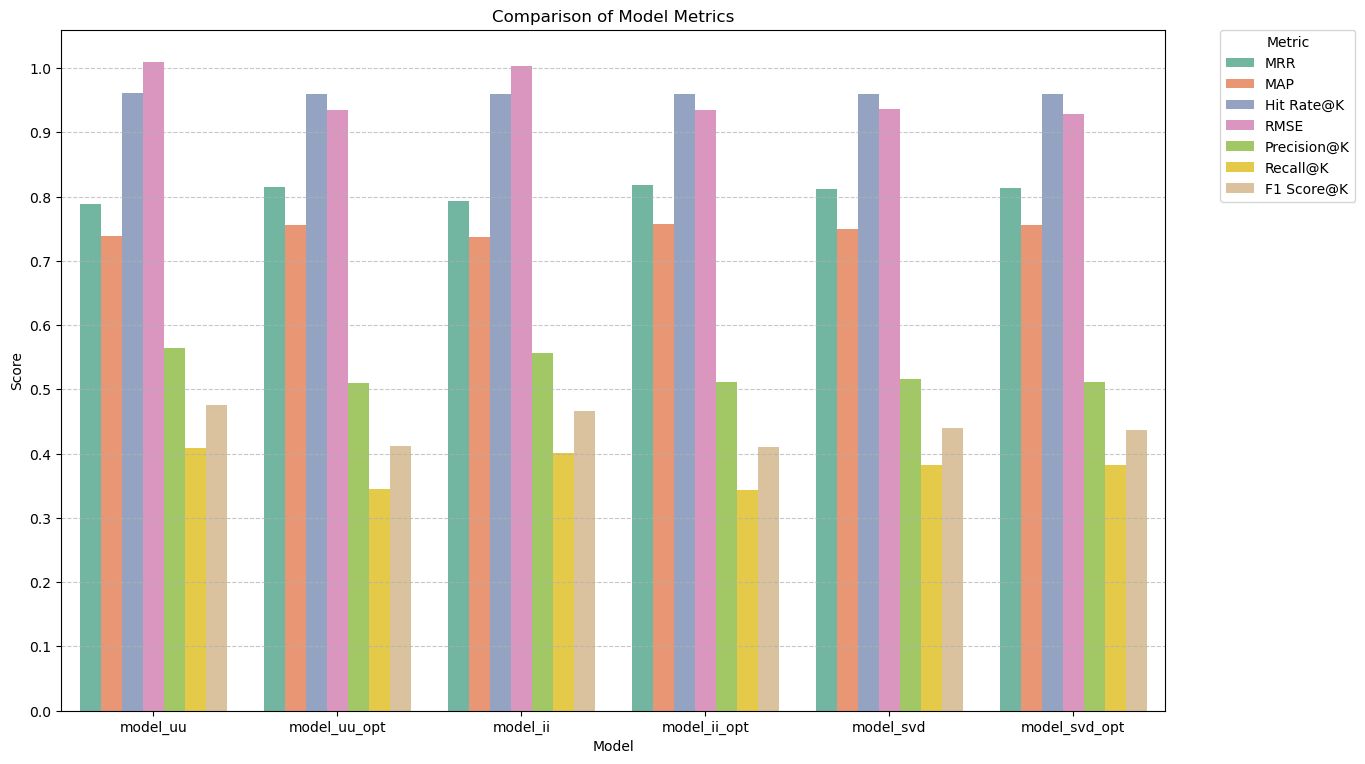

In [190]:
# Combine all metrics into a single dictionary
metrics = {
    "model_uu": model_uu_metric,
    "model_uu_opt": model_uu_opt_metric,
    "model_ii": model_ii_metric,
    "model_ii_opt": model_ii_opt_metric,
    "model_svd": model_svd_metric,
    "model_svd_opt": model_svd_opt_metric,
}

# Convert the dictionary to a DataFrame
metrics_df = pd.DataFrame(metrics).T

# Print the DataFrame without wrapping
with pd.option_context("display.max_colwidth", None, "display.width", 1000):
    print("-" * 82)
    print(metrics_df)
    print("-" * 82)

# Melt the DataFrame to a long format suitable for Seaborn
metrics_df.reset_index(inplace=True)
metrics_long = pd.melt(
    metrics_df, id_vars="index", var_name="Metric", value_name="Score"
)

# Rename columns for clarity
metrics_long.columns = ["Model", "Metric", "Score"]

# Plot
plt.figure(figsize=(14, 8))
sns.barplot(x="Model", y="Score", hue="Metric", palette="Set2", data=metrics_long)
plt.title("Comparison of Model Metrics")
plt.legend(
    title="Metric", bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.0
)
plt.yticks(np.arange(0, 1.1, 0.1))  # Grid every 0.1

# Add a grid and adjust layout for better spacing
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout(pad=2.0)

plt.show()

In [197]:
metrics_df

,index,MRR,MAP,Hit Rate@K,RMSE,Precision@K,Recall@K,F1 Score@K
0,model_uu,0.788,0.739,0.961,1.009,0.565,0.409,0.475
1,model_uu_opt,0.815,0.756,0.960,0.934,0.510,0.345,0.412
2,model_ii,0.793,0.737,0.960,1.004,0.557,0.401,0.466
3,model_ii_opt,0.818,0.757,0.960,0.934,0.511,0.344,0.411
4,model_svd,0.812,0.750,0.960,0.936,0.516,0.383,0.440
5,model_svd_opt,0.814,0.756,0.960,0.928,0.511,0.382,0.437


In [198]:
metrics_long

,Model,Metric,Score
0,model_uu,MRR,0.788
1,model_uu_opt,MRR,0.815
2,model_ii,MRR,0.793
3,model_ii_opt,MRR,0.818
4,model_svd,MRR,0.812
5,model_svd_opt,MRR,0.814
6,model_uu,MAP,0.739
7,model_uu_opt,MAP,0.756
8,model_ii,MAP,0.737
9,model_ii_opt,MAP,0.757


----------------------------------------------------------------------------------
                 MRR    MAP  Hit Rate@K   RMSE  Precision@K  Recall@K  F1 Score@K
model_uu       0.788  0.739       0.961  1.009        0.565     0.409       0.475
model_uu_opt   0.815  0.756       0.960  0.934        0.510     0.345       0.412
model_ii       0.793  0.737       0.960  1.004        0.557     0.401       0.466
model_ii_opt   0.818  0.757       0.960  0.934        0.511     0.344       0.411
model_svd      0.812  0.750       0.960  0.936        0.516     0.383       0.440
model_svd_opt  0.814  0.756       0.960  0.928        0.511     0.382       0.437
----------------------------------------------------------------------------------


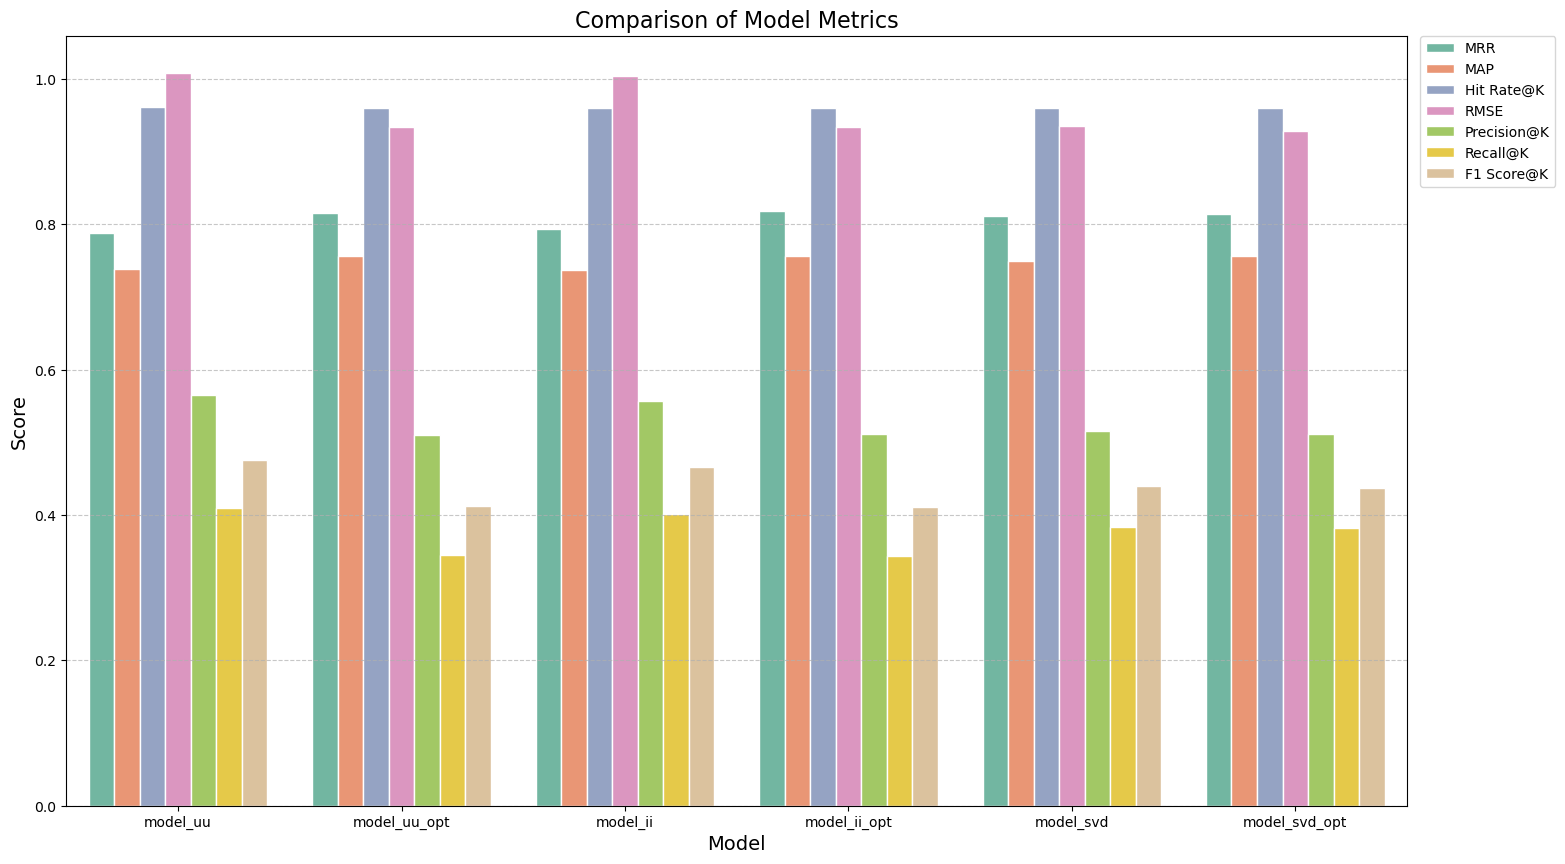

In [206]:
# Combine all metrics into a single dictionary
metrics = {
    "model_uu": model_uu_metric,
    "model_uu_opt": model_uu_opt_metric,
    "model_ii": model_ii_metric,
    "model_ii_opt": model_ii_opt_metric,
    "model_svd": model_svd_metric,
    "model_svd_opt": model_svd_opt_metric,
}

# Convert the dictionary to a DataFrame
metrics_df = pd.DataFrame(metrics).T

# Print the DataFrame without wrapping
with pd.option_context("display.max_colwidth", None, "display.width", 1000):
    print("-" * 82)
    print(metrics_df)
    print("-" * 82)

# Melt the DataFrame to a long format suitable for Seaborn
metrics_df.reset_index(inplace=True)
metrics_long = pd.melt(
    metrics_df, id_vars="index", var_name="Metric", value_name="Score"
)

# Rename columns for clarity
metrics_long.columns = ["Model", "Metric", "Score"]

# Improved visualization
plt.figure(figsize=(16, 9))
sns.barplot(
    x="Model",
    y="Score",
    hue="Metric",
    palette="Set2",
    data=metrics_long,
    edgecolor="white",
)

# Improve the legend by placing it outside the plot
plt.legend(bbox_to_anchor=(1.01, 1), loc="upper left", borderaxespad=0.0)

# Add a title and labels
plt.title("Comparison of Model Metrics", fontsize=16)
plt.xlabel("Model", fontsize=14)
plt.ylabel("Score", fontsize=14)

# Add a grid and adjust layout for better spacing
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout(pad=2.0)

# Show the plot
plt.show()

In [210]:
from sklearn.preprocessing import OneHotEncoder
import numpy as np

# Assuming 'df' is your DataFrame with columns 'user_id', 'prod_id', 'rating'

# Convert 'prod_id' to a one-hot encoded feature matrix
encoder = OneHotEncoder(sparse_output=False)
prod_features = encoder.fit_transform(df[["prod_id"]])

In [236]:
df[:1]

,user_id,prod_id,rating
0,A3BMUBUC1N77U8,0972683275,4.0


In [218]:
def calculate_item_popularity(data):
    """
    Calculate the popularity of each item in the dataset.

    Parameters:
    - data: A pandas DataFrame containing user-item interactions with columns 'user_id' and 'item_id'.

    Returns:
    - A dictionary where keys are item IDs and values are the number of interactions (popularity).
    """
    item_popularity = data["prod_id"].value_counts().to_dict()
    return item_popularity


# Example usage:
item_popularity = calculate_item_popularity(
    df
)  # Assuming `df` is your interactions DataFrame

In [219]:
def calculate_item_novelty(item_popularity):
    """
    Calculate the novelty of each item based on its popularity.

    Parameters:
    - item_popularity: A dictionary where keys are item IDs and values are their popularity (number of interactions).

    Returns:
    - A dictionary where keys are item IDs and values are the novelty scores.
    """
    total_items = len(item_popularity)
    item_novelty = {
        item: 1 / (1 + popularity) for item, popularity in item_popularity.items()
    }
    return item_novelty


# Example usage:
item_novelty = calculate_item_novelty(item_popularity)

In [234]:
def get_recommendations_per_user(data, model, top_n=5):
    recommendations_per_user = {}
    unique_users = data["user_id"].unique()
    for user in unique_users:
        recommendations = get_recommendations(
            data=data, user_id=user, top_n=top_n, algo=model.model
        )
        recommendations_per_user[user] = recommendations
    return recommendations_per_user


recommendations_per_user = get_recommendations_per_user(df, model=model_svd)

In [238]:
def calculate_recommendation_novelty(recommendations_per_user, item_novelty):
    """
    Calculate the novelty score for the recommendations of each user.

    Parameters:
    - recommendations_per_user: A dictionary where keys are user IDs and values are lists of recommended item IDs.
    - item_novelty: A dictionary where keys are item IDs and values are the novelty scores.

    Returns:
    - A dictionary where keys are user IDs and values are their average recommendation novelty scores.
    """
    novelty_scores = {}

    for user, recommended_items in recommendations_per_user.items():
        novelty_sum = sum(item_novelty[item] for item in recommended_items)
        novelty_scores[user] = novelty_sum / len(recommended_items)

    return novelty_scores


# Example usage:
novelty_scores = calculate_recommendation_novelty(
    recommendations_per_user, item_novelty
)
print(f"Recommendation Novelty Scores: {novelty_scores}")

KeyError: 'prod_id'

In [ ]:
def calculate_overall_novelty_score(novelty_scores):
    """
    Calculate the overall novelty score across all users.

    Parameters:
    - novelty_scores: A dictionary where keys are user IDs and values are their average recommendation novelty scores.

    Returns:
    - The overall novelty score.
    """
    overall_novelty = sum(novelty_scores.values()) / len(novelty_scores)
    return overall_novelty


# Example usage:
overall_novelty_score = calculate_overall_novelty_score(novelty_scores)
print(f"Overall Recommendation Novelty Score: {overall_novelty_score}")

In [231]:
import pandas as pd


def get_recommendations(data, user_id, top_n, algo):
    """
    This function recommends top_n products for a given user based on the specified algorithm.

    Parameters:
    - data: A rating dataset (DataFrame)
    - user_id: The user id for which recommendations are needed
    - top_n: The number of products to recommend
    - algo: The algorithm to use for predicting ratings

    Output:
    - A DataFrame of top_n items recommended for the given user_id based on the given algorithm
    """

    # Creating an empty list to store the recommended product ids
    recommendations = []

    # Creating a user-item interactions matrix
    user_item_interactions_matrix = data.pivot(
        index="user_id", columns="prod_id", values="rating"
    )

    # Check if the user_id exists in the matrix
    if user_id not in user_item_interactions_matrix.index:
        raise ValueError(f"User ID {user_id} not found in the dataset.")

    # Extracting those product ids which the user_id has not interacted yet
    non_interacted_products = user_item_interactions_matrix.loc[user_id][
        user_item_interactions_matrix.loc[user_id].isnull()
    ].index.tolist()

    # Looping through each of the product ids which user_id has not interacted yet
    for item_id in non_interacted_products:
        # Predicting the ratings for those non-interacted product ids by this user
        prediction = algo.predict(user_id, item_id)
        est = prediction.est
        details = prediction.details

        # Appending the predicted ratings
        recommendations.append((item_id, est, details))

    # Sorting the predicted ratings in descending order
    recommendations.sort(key=lambda x: x[1], reverse=True)

    # Convert recommendations to DataFrame and round predicted ratings
    recommendations_df = pd.DataFrame(
        recommendations[:top_n],
        columns=["prod_id", "estimated_ratings", "details"],
    ).assign(estimated_ratings=lambda df: df["estimated_ratings"].round(2))

    # Returning top n highest predicted rating products for this user
    return recommendations_df